In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl

try:
    data_path = mpl.get_data_path()
    print(data_path)
except AttributeError:
    print("The 'get_data_path' function is not available in this version of matplotlib.")
    print("Using an alternative method to retrieve the data path...")
    data_path = mpl.get_configdir() + '/mpl-data'
    print(data_path)

/usr/local/lib/python3.10/site-packages/matplotlib/mpl-data


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sns.set(font_scale = 2)
sns.set_style("whitegrid")
LW = 3
MS = 10

In [17]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

In [24]:
from ethprivacy.entity_api import EntityAPI
from ethprivacy.topic_analysis import *
from ethprivacy.tornado_mixer import TornadoQueries

In [25]:
export_figs = True

# 1.) Initialize EntityAPI

In [26]:
data_dir = "../data/"
output_dir = "../results/"

In [27]:
img_dir = "%s/figs" % output_dir
if export_figs and not os.path.exists(img_dir):
    os.makedirs(img_dir)

In [29]:
api_all = EntityAPI(data_dir, only_pos_tx=False)

ens_pairs (1400, 2)
normal_txs (1137558, 11)
token_txs (495116, 20)
normal_graph (92281, 1137558)
token_graph (83066, 495116)
contract_graph (32757, 495116)
rev_contract_graph (71544, 495116)
Number of unique ENS names: 890
Number of Etherscan events: 1632674
Number of unique tx hashes: 1155188
Number of accounts: 159339
min time 2015-07-30 15:26:13
max time 2020-04-04 00:13:28


# 2.) Data check

### Activity plots

### Gas price

In [33]:
gas_price_df = df.groupby(["day"])["gasPrice"].mean().reset_index()

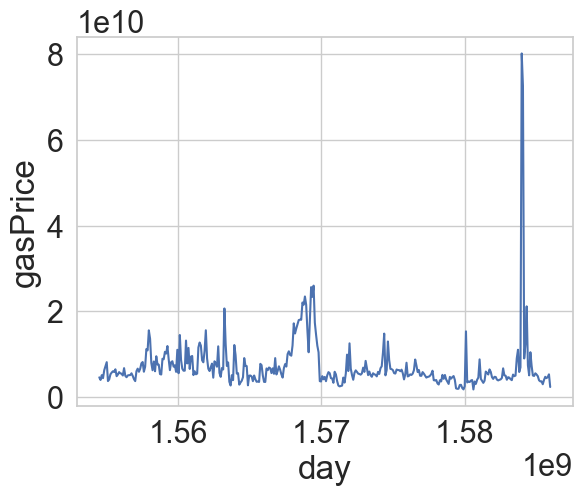

In [34]:
g = sns.lineplot(data = gas_price_df, x="day", y="gasPrice")

### Address statistics

In [35]:
print("Unique contract addresses", len(api_all.events["contractAddress"].unique()))

Unique contract addresses 11339


In [36]:
print("Unique addresses", len(set(api_all.events["from"]).union(set(api_all.events["to"]))))
print("Unique senders", len(set(api_all.events["from"])))
print("Unique receivers", len(set(api_all.events["to"])))

Unique addresses 159339
Unique senders 78164
Unique receivers 100756


In [37]:
sent_tx_cnt = dict(api_all.events["from"].value_counts())

### Addresses of interest

In [38]:
addresses, ens_addresses, tornado_addresses, humanity_dao_addresses = addresses_of_interest(api_all, with_tornado=True, with_hd=True)

Number of ENS names: 890
Number of ENS addresses: 1400
Number of Tornado addresses: 2871
Number of Humanity-Dao addresses: 701
Number of all addresses: 4810


### Sent/received tx cnt for the 3 data source

In [39]:
df = api_all.events

In [40]:
num_sent_txs = df["from"].value_counts()
num_received_txs = df["to"].value_counts()

In [41]:
records = []
for set_name, addr_set in [("Twitter",ens_addresses),("Tornado",tornado_addresses),("Humanity-Dao",humanity_dao_addresses)]:
    keys = set(addr_set).intersection(num_sent_txs.index)
    records.append([set_name, num_sent_txs.loc[keys].mean(), "sent"])
    keys = set(addr_set).intersection(num_received_txs.index)
    records.append([set_name, num_received_txs.loc[keys].mean(), "received"])
mean_txs_cnt = pd.DataFrame(records, columns=["Source","Average tx count","Direction"])

/var/folders/3v/djh89n8d1sg02jc6wtj1dyx40000gn/T/ipykernel_14139/2569772365.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  records.append([set_name, num_sent_txs.loc[keys].mean(), "sent"])
/var/folders/3v/djh89n8d1sg02jc6wtj1dyx40000gn/T/ipykernel_14139/2569772365.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  records.append([set_name, num_received_txs.loc[keys].mean(), "received"])
/var/folders/3v/djh89n8d1sg02jc6wtj1dyx40000gn/T/ipykernel_14139/2569772365.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  records.append([set_name, num_sent_txs.loc[keys].mean(), "sent"])
/var/folders/3v/djh89n8d1sg02jc6wtj1dyx40000gn/T/ipykernel_14139/2569772365.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  record

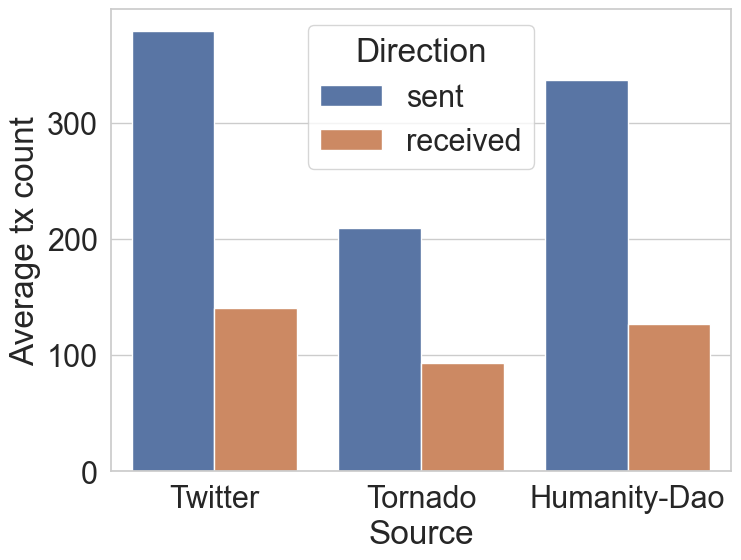

In [42]:
plt.figure(figsize=(8,6))
g = sns.barplot(data=mean_txs_cnt, x="Source", y="Average tx count", hue="Direction")
if export_figs:
    plt.savefig("%s/avg_txs.pdf" % img_dir, format='pdf', bbox_inches='tight')

### Number of addresses per ENS

In [43]:
cnt_map = dict(api_all.ens_pairs["name"].value_counts().value_counts())
more_map = cnt_map.copy()
del more_map[1]
del more_map[2]
del more_map[3]
del more_map[4]
del more_map[5]

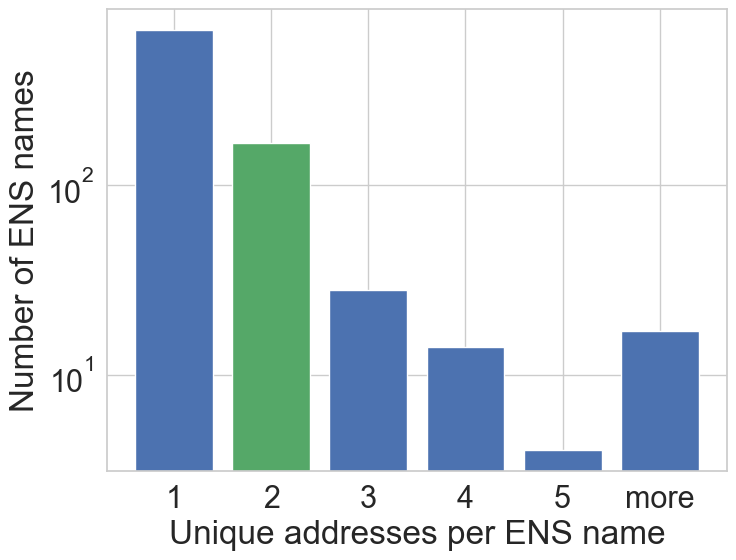

In [44]:
cols = ['1','2','3','4','5','more']
vals = [cnt_map[1],cnt_map[2],cnt_map[3],cnt_map[4],cnt_map[5],sum(more_map.values())]
plt.figure(figsize=(8,6))
plt.bar(cols,vals,color=['b','g','b','b','b','b'])
plt.yscale('log')
plt.xlabel("Unique addresses per ENS name")
plt.ylabel("Number of ENS names")
plt.yticks([10,10**2])
if export_figs:
    plt.savefig("%s/addr_cnt_for_ens.pdf" % img_dir, format='pdf', bbox_inches='tight')

# 3. Tornado mixers

In [45]:
max_time = api_all.events["timeStamp"].max()
print(max_time)

1585959208


In [46]:
tq0_1 = TornadoQueries(mixer_str_value="0.1", max_time=max_time, data_folder=data_dir)
tq1 = TornadoQueries(mixer_str_value="1", max_time=max_time, data_folder=data_dir)
tq10 = TornadoQueries(mixer_str_value="10", max_time=max_time, data_folder=data_dir)
tq100 = TornadoQueries(mixer_str_value="100", max_time=max_time, data_folder=data_dir)

Loops removed: 1.0
Tornado address removed: 0.9919354838709677
history (2906, 8)
pairs (121, 5)
Loops removed: 0.9775280898876404
Tornado address removed: 0.9775280898876404
history (1828, 8)
pairs (85, 5)
Loops removed: 0.9230769230769231
Tornado address removed: 0.9230769230769231
history (1612, 8)
pairs (47, 5)
Loops removed: 1.0
Tornado address removed: 1.0
history (302, 8)
pairs (5, 5)


In [47]:
import matplotlib.dates as mdates

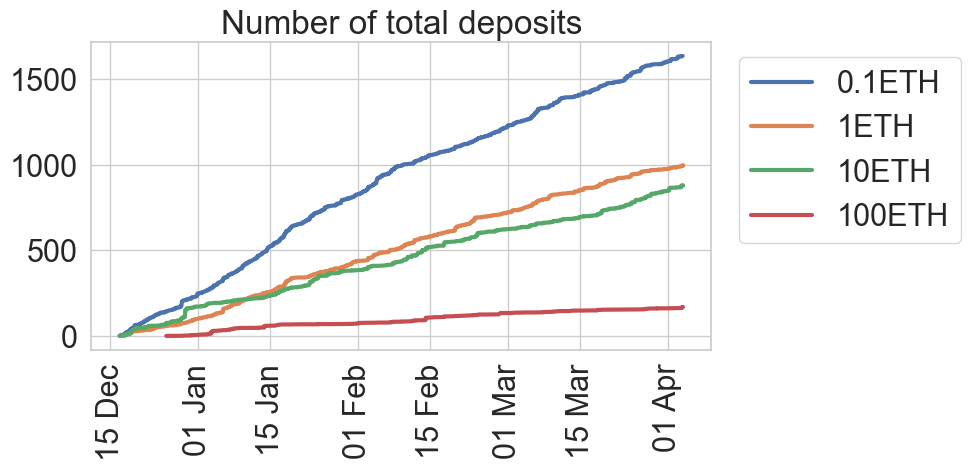

In [48]:
fig, ax = plt.subplots(figsize=(8,4))
plt.title("Number of total deposits")
tq0_1.plot_num_deposits(show_heuristics=False, linew=LW, msize=MS)
tq1.plot_num_deposits(show_heuristics=False, linew=LW, msize=MS)
tq10.plot_num_deposits(show_heuristics=False, linew=LW, msize=MS)
tq100.plot_num_deposits(show_heuristics=False, linew=LW, msize=MS)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
plt.legend(bbox_to_anchor=(1.02, 1.0))
if export_figs:
    plt.savefig("%s/tornado_active_deposits.pdf" % img_dir, format='pdf', bbox_inches='tight')

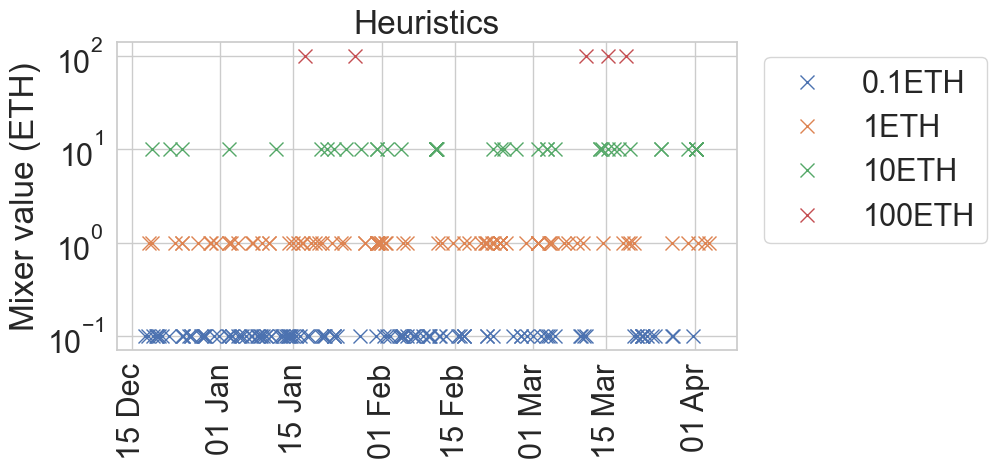

In [49]:
fig, ax = plt.subplots(figsize=(8,4))
plt.title("Heuristics")
tq0_1.plot_num_deposits(show_heuristics=True)
tq1.plot_num_deposits(show_heuristics=True)
tq10.plot_num_deposits(show_heuristics=True)
tq100.plot_num_deposits(show_heuristics=True)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
plt.yscale("log")
plt.ylabel("Mixer value (ETH)")
plt.yticks([0.1,1.0,10.0,100.0])
plt.legend(bbox_to_anchor=(1.02, 1.0))
if export_figs:
    plt.savefig("%s/tornado_heuristics.pdf" % img_dir, format='pdf', bbox_inches='tight')

# 4.) Topic Analysis

In [50]:
api = EntityAPI(data_dir, only_pos_tx=False, address_filter="ens")

ens_pairs (1400, 2)
normal_txs (529431, 11)
token_txs (177453, 20)
normal_graph (44560, 529431)
token_graph (38372, 177453)
contract_graph (15957, 177453)
rev_contract_graph (34889, 177453)
Number of unique ENS names: 890
Number of Etherscan events: 706884
Number of unique tx hashes: 526547
Number of accounts: 75107
min time 2015-08-11 09:58:48
max time 2020-04-04 00:13:28


## i.) Load topics

In [51]:
topic_for_addr, name_for_addr = load_address_topics("%s/labeledAddresses.json" % data_dir)

Phishing
Adult
Defi
Gaming
Privacy
StableCoins
Travel
Vehicle
Social
Platform
Mobile
IoT
Gold
Gambling
Donate/Fund
Exchange
Entertainment
Education
Wallet
Trading
ENS Service
Collectibles
MakerDaoV2PriceFeeders
Insurance/Healthcare


In [52]:
selected_addresses = list(topic_for_addr.keys())

## ii.) Find these addresses in our data

In [53]:
info_records = [api.address_info(addr) for addr in tqdm(selected_addresses)]
selected_addr_info = pd.DataFrame(info_records)

100%|██████████| 329/329 [01:02<00:00,  5.28it/s]


In [54]:
selected_addr_info["topic"] = selected_addr_info["address"].apply(lambda x: topic_for_addr[x])
selected_addr_info["name"] = selected_addr_info["address"].apply(lambda x: name_for_addr[x])

In [55]:
selected_addr_info["has_event"] = selected_addr_info.apply(lambda x: x["is_contract"] or x["normal_in"] or x["normal_out"] or x["token_in"] or x["token_out"], axis=1)

In [56]:
selected_addr_info["has_event"].value_counts() / len(selected_addr_info)

True     0.6231
False    0.3769
Name: has_event, dtype: float64

### Keep only addresses with events

In [57]:
selected_addr_info = selected_addr_info[selected_addr_info["has_event"]]
selected_addr_info.shape

(205, 10)

### Topic distribution for interacted addresses

In [58]:
selected_addr_info["topic"].value_counts()

Exchange                33
Gaming                  18
Donate/Fund             16
Insurance/Healthcare    15
Social                  14
Gambling                12
Entertainment           12
Trading                 11
Platform                11
Wallet                  10
Defi                    10
IoT                      7
Privacy                  6
Mobile                   6
StableCoins              4
ENS Service              4
Gold                     3
Education                3
Vehicle                  3
Travel                   3
Collectibles             2
Adult                    2
Name: topic, dtype: int64

In [59]:
selected_addr_info

,is_contract,normal_in,normal_out,token_in,token_out,address,ens_names,topic,name,has_event
1,True,True,False,False,False,0x6b01c3170ae1efebee1a3159172cb3f7a5ecf9e5,[],Adult,BOOTY,True
2,True,True,False,False,False,0x42d6622dece394b54999fbd73d108123806f6a18,[],Adult,SpankChain,True
8,True,True,False,False,False,0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2,[],Defi,Maker,True
9,False,True,False,False,False,0x818e6fecd516ecc3849daf6845e3ec868087b755,[],Defi,KyberNetwork,True
10,True,True,False,True,True,0x39aa39c021dfbae8fac545936693ac917d5e7563,[],Defi,CompoundUSD,True
...,...,...,...,...,...,...,...,...,...,...
316,True,True,False,False,False,0x737fa0372c8d001904ae6acaf0552d4015f9c947,[],Insurance/Healthcare,MEDIBIT,True
318,True,True,False,False,False,0x66186008c1050627f979d464eabb258860563dbe,[],Insurance/Healthcare,MediShares,True
323,True,True,False,False,False,0x2aec18c5500f21359ce1bea5dc1777344df4c0dc,[],Insurance/Healthcare,FarmaTrust,True
324,True,True,False,False,False,0x70c621f949b6556c4545707a2d5d73a776b98359,[],Insurance/Healthcare,Skychain,True


## iii.) Discover address connections

Find the set of ens names that were in contact with these interesting addresses

In [60]:
selected_addr_info["name"] = selected_addr_info["name"].replace({"gemini1":"Gemini",'EtherDelta 2':'EtherDelta','bittrex1':'Bittrex'})

In [61]:
inbound, outbound = get_in_out_ens_connections(api, selected_addr_info)

  0%|          | 0/205 [00:00<?, ?it/s]/Users/khushpatel/Desktop/eth-privacy/ipython/ethprivacy/entity_api.py:39: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  out_neighbors = dict(out_links.groupby("src")["trg"].apply(set))
/Users/khushpatel/Desktop/eth-privacy/ipython/ethprivacy/entity_api.py:37: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this war

### Merge a few services

In [62]:
sorted(selected_addr_info[selected_addr_info["topic"]=="Exchange"]["name"].unique())

['BNB',
 'BitMart',
 'Bliss Exchange Token',
 'CDEX',
 'CGCX Exchange',
 'Cobinhood',
 'Coineal',
 'Eterbase Coin',
 'EtherDelta',
 'FOX',
 'Gemini',
 'HuobiToken',
 'Kucoin Shares',
 'LGO',
 'MetaMorph',
 'OKB',
 'Poloniex1',
 'Poloniex4',
 'QASH',
 'TOPBTC',
 'Tcash',
 'Trade Token X',
 'binance2',
 'binance3',
 'binance4',
 'binance5',
 'binance6',
 'bitfinex2',
 'kraken1',
 'kraken2',
 'kraken4',
 'okex1',
 'okex2']

In [63]:
to_be_merged = {
    "Exchange":{
        "Poloniex":['Poloniex1','Poloniex4'],
        "Binance":['binance2','binance3','binance4','binance5','binance6'],
        "Kraken":['kraken1','kraken2','kraken4'],
        "Okex":['okex1','okex2']
    },
    "Gaming":{
        "CryptoKitties":['CryptoKitties','CryptoKitties String Auction','Cryptokitties Sales']
    }
}

In [64]:
for topic in to_be_merged:
    topic_merges = to_be_merged[topic]
    for key in topic_merges:
        merged = set()
        for ens_dict in [inbound, outbound]:
            for val in topic_merges[key]:
                merged = merged.union(ens_dict[topic][val])
                del ens_dict[topic][val]
            ens_dict[topic][key] = merged

In [65]:
num_uniq_ens = len(api.ens_pairs["name"].unique())
num_uniq_ens

890

In [66]:
total_for_names = calculate_ens_coverage(inbound, outbound, num_uniq_ens)
total_for_topics = calculate_ens_coverage(inbound, outbound, num_uniq_ens, result_type="topic")

In [67]:
total_for_topics["frac_order"] = total_for_topics["frac"].rank(ascending=False)
total_for_names["frac_order"] = total_for_names["frac"].rank(ascending=False)
total_for_names["name - topic"] = total_for_names[["name","topic"]].apply(lambda x: str(x["name"]) + " - " + str(x["topic"]), axis=1)

In [68]:
num_uniq_ens, len(api.ens_pairs)

(890, 1400)

## iv.) Visualize

### a.) Topic statistics

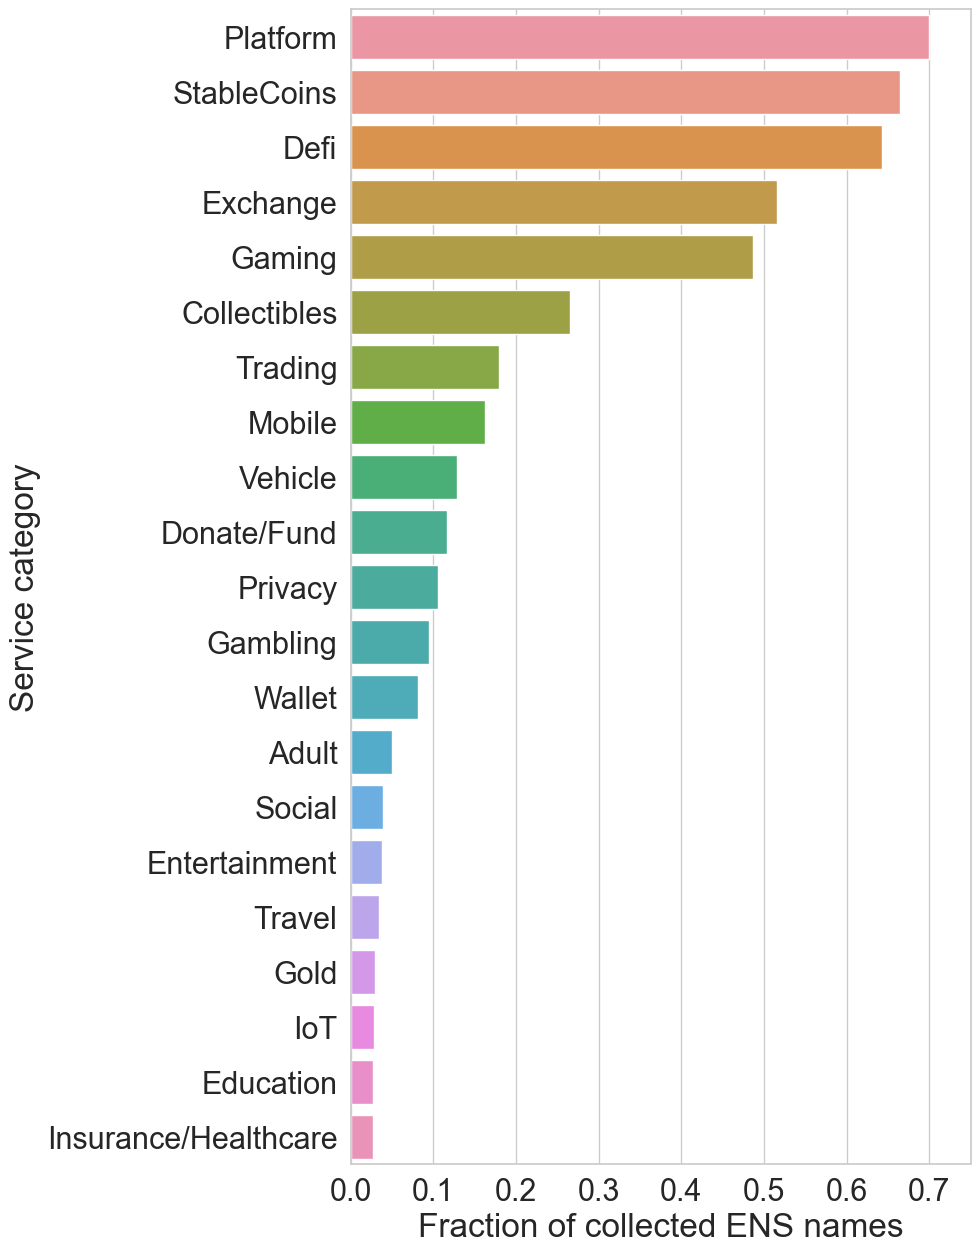

In [69]:
df = total_for_topics.sort_values("frac_order").reset_index().drop(0)
fig, ax = plt.subplots(1,1,figsize=(8,15))
g = sns.barplot(data=df, y="topic",x="frac", orient="h", ax=ax)
g.set(xlabel="Fraction of collected ENS names")
g.set(xlim=(0,df["frac"].max()+0.05))
g.set(xticks=np.arange(0,df["frac"].max()+0.05,0.1))
g.set(ylabel="Service category")
if export_figs:
    plt.savefig("%s/ens_topic_distrib.pdf" % img_dir, format='pdf', bbox_inches='tight')